## AML Project : Polish Bankruptcy Data
*Algorithm : Thresholding*

In [16]:
! pip install plot_utils &>devnull

In [17]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

'''Algorithms'''
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import keras as K
import tensorflow as tf



<font color= 'blue'>Loading Datasets</font>


---



In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
path = '/content/drive/MyDrive/3. IU Courses/Courses/4. Applied Machine Learning/Project_Shared/Data Folder'

In [20]:
data_1 = pd.read_excel(os.path.join(path, "year1.xlsx"))
data_2 = pd.read_excel(os.path.join(path, "year2.xlsx"))
data_3 = pd.read_excel(os.path.join(path, "year3.xlsx"))
data_4 = pd.read_excel(os.path.join(path, "year4.xlsx"))
data_5 = pd.read_excel(os.path.join(path, "year5.xlsx"))

<font color = 'blue'> Modeling Functions</font>

---



In [21]:
def assign_class(predicted_prob, threshold):
  label = (predicted_prob>= threshold).astype(int)
  return label

In [22]:
def thresholding_model (data, scaling_type, test_size, threshold_list,
                        max_epochs, batch_size, activation_func):

  # Seprating features from class variables
  X = data.drop(['class', 'df_year'] , axis = 1)
  y = data['class']

  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size = test_size, 
                                                      random_state = 42, 
                                                      stratify=y)
  # Select scaling type
  if scaling_type == "RobustScaler":
    sc = pp.RobustScaler()
  else:
    sc = pp.StandardScaler()

  X_train = sc.fit_transform(X_train)
  X_test = sc.transform(X_test)
  feature_shape = X_train.shape[1]

  # Model Fit
  my_init = K.initializers.glorot_uniform(seed=1)
 
  model = K.models.Sequential()  
  model.add(K.layers.Dense(units=16, input_dim = feature_shape, activation = activation_func, kernel_initializer=my_init)) 
  model.add(K.layers.Dense(units=16, activation = activation_func , kernel_initializer=my_init))  
  model.add(K.layers.Dense(units=1, activation='sigmoid', kernel_initializer=my_init)) 
 
  K_optimizer =  tf.keras.optimizers.Adam(learning_rate = 0.01, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)  
  
  model.compile(loss='binary_crossentropy', 
                optimizer = K_optimizer, metrics=[tf.keras.metrics.Recall()]) # tf.keras.metrics.AUC()

  model.fit(X_train, y_train, batch_size = batch_size, epochs=max_epochs, verbose=0)

  # Model Prediction
  
  y_prob = model.predict(X_test)   
  
  scores = [f1_score(y_test, assign_class(y_prob, t)) for t in threshold_list]
  
  pos_best = np.argmax(scores) # Position of best F1 score  
  y_pred = assign_class(y_prob, threshold_list[pos_best])
  
  return threshold_list[pos_best], y_test, y_pred, y_prob

In [23]:
def performance_metrics(y_testset, y_predicted):
  
  # Metrics
  accuracy = accuracy_score(y_testset, y_predicted)
 
  # precision tp / (tp + fp)
  precision = precision_score(y_testset, y_predicted)
 
  # recall: tp / (tp + fn)
  recall = recall_score(y_testset, y_predicted)
 
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_testset, y_predicted) 

  # AUC
  auc = roc_auc_score(y_testset, y_predicted)
  
  return accuracy, precision, recall, f1, auc


In [24]:
def conf_matrix(y_testset, y_predicted, data_name):
  
  # Creating Confusion Matrix
  cf_matrix = confusion_matrix(y_testset, y_predicted)

  fig = plt.gcf()
  fig.set_size_inches(9, 6)
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')
  ax.set_title('Confusion Matrix on Test Set');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');
  plt.show()

  return

In [25]:
def plot_roc_curve(y_testset, model_prob, n, axes1, auc):
  
  false_positive_rate, true_positive_rate, thresolds_ = roc_curve(y_testset, model_prob)
      
  
  #plt.figure(figsize=(4, 6), dpi=100)
  axes1[n-1].axis('scaled')
  axes1[n-1].set_xlim([0, 1])
  axes1[n-1].set_ylim([0, 1])
  axes1[n-1].plot([0,1], [0,1], linestyle='--',linewidth = 1)
  axes1[n-1].plot(false_positive_rate, true_positive_rate, 'lightblue')  
  axes1[n-1].fill_between(false_positive_rate, true_positive_rate, facecolor='orange', alpha=0.8)
  axes1[n-1].text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, color='black')
  axes1[n-1].set_xlabel("False Positive Rate")
  axes1[n-1].set_ylabel("True Positive Rate")
  axes1[n-1].title.set_text(f'Year{str(n)} - AUC & ROC Curve')
  
  #plt.show()
  
  return

<font color ='blue'> Model Results </font>

---



In [26]:
# For Summary Results & comparison
plot_data = {'Data_Name':[], 'Accuracy': [], "Precision": [],
             "Recall": [], 'F1_score': [], 'Scale_Type': [], 'AUC':[],
             'Test_size' : [], 'Model' : [], 'Activation' :[] }

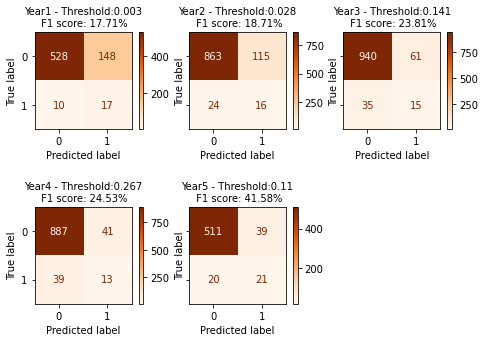

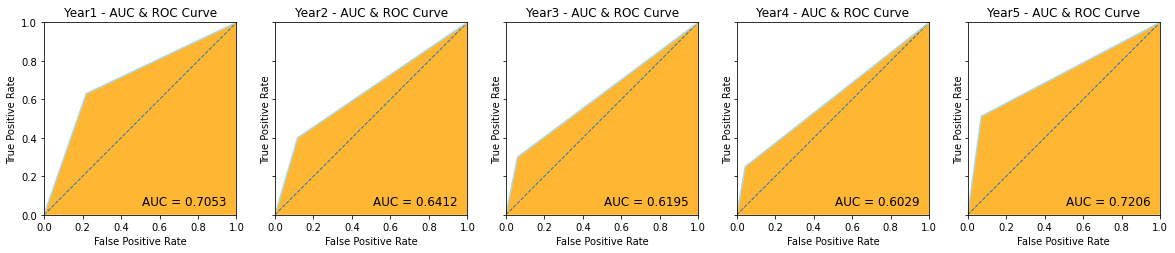

In [27]:
# Input Values

datasets = [data_1, data_2, data_3, data_4, data_5]
n = 1

# Hyperparameters
scaling = "RobustScaler" # ["RobustScaler" , "StandardScaler"]
test_size = .1
thresholds = np.arange(0, 1, 0.001)
Model = "Thresholding"
epochs, batch = 1000, 100
activation = 'tanh' #['relu', 'tanh']
i = 0
f, axes = plt.subplots(2, 3, figsize=(8, 5), sharey='row')
axes = axes.flatten()
f1, axes1 = plt.subplots(1, 5, figsize=(20, 4), sharey='row')

for df in datasets:
 
  data_name = 'Year' + str(n) 
  threshold, y_testset, y_predicted, y_prob = thresholding_model(df,scaling_type = scaling, 
                                                         test_size = test_size, 
                                                         threshold_list = thresholds, 
                                                         max_epochs = epochs,
                                                         batch_size = batch,
                                                         activation_func = activation)
  
  accuracy, precision, recall, f1, auc = performance_metrics(y_testset, y_predicted)
  
  plot_data['Data_Name'].append(data_name)
  plot_data['Accuracy'].append(accuracy)
  plot_data['Precision'].append(precision)
  plot_data['Recall'].append(recall)
  plot_data['F1_score'].append(f1)
  plot_data['Scale_Type'].append(scaling)
  plot_data['Test_size'].append(test_size)
  plot_data['Model'].append('Thresholding') # Change as per model
  plot_data['Activation'].append(activation)
  plot_data['AUC'].append(auc)

  #print(f'Confusion matrix for dataset {data_name}')
  #print(f'Threshold: {threshold} F1 score: {f1:.5%}')
  plot_roc_curve(y_testset, y_predicted, n, axes1, auc)
  # conf_matrix(y_testset, y_predicted, data_name = data_name)
  cm = confusion_matrix(y_testset, y_predicted)
  cmd = ConfusionMatrixDisplay(cm)
  cmd.plot(cmap='Oranges', ax=axes[i])
  # axes[i].title.set_text(f'Year{str(n)} - Threshold:{np.round(threshold,4)}\n F1 score: {f1:.2%}')
  axes[i].set_title(f'Year{str(n)} - Threshold:{np.round(threshold,4)}\n F1 score: {f1:.2%}', fontsize = 10)
  axes[5].set_axis_off()
  i+=1
  n+=1
#f.tight_layout()
f.subplots_adjust(hspace=.8)
f.subplots_adjust(wspace=0.12)
plt.show()
  

In [28]:
Performance_numbers = pd.DataFrame(plot_data)

In [29]:
Performance_numbers

,Data_Name,Accuracy,Precision,Recall,F1_score,Scale_Type,AUC,Test_size,Model,Activation
0,Year1,0.775249,0.103030,0.629630,0.177083,RobustScaler,0.705347,0.1,Thresholding,tanh
1,Year2,0.863458,0.122137,0.400000,0.187135,RobustScaler,0.641207,0.1,Thresholding,tanh
2,Year3,0.908658,0.197368,0.300000,0.238095,RobustScaler,0.619530,0.1,Thresholding,tanh
3,Year4,0.918367,0.240741,0.250000,0.245283,RobustScaler,0.602909,0.1,Thresholding,tanh
4,Year5,0.900169,0.350000,0.512195,0.415842,RobustScaler,0.720643,0.1,Thresholding,tanh


In [30]:
# Change Filename as per model
Performance_numbers.to_excel(os.path.join(path, 'Thresholding_Results.xlsx'), index=False) 